# 17장 세상에 없는 얼굴 GAN, 오토인코더

[<img src="https://raw.githubusercontent.com/taehojo/taehojo.github.io/master/assets/images/linktocolab.png" align="left"/> ](https://colab.research.google.com/github/taehojo/deeplearning/blob/master/colab/ch17-colab.ipynb)

## 3. 적대적 신경망 실행하기

### 실습: GAN 모델 만들기

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 28, 28, 1)           │         865,281 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         212,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
epoch:0  d_loss:0.7311  g_loss:0.7190
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
epoch:100  d_loss:0.4847  g_loss:1.7822
epoch:200  d_loss:0.4763  g_loss:1.8269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
epoch:300  d_loss:0.4613  g_loss:2.0399
epoch:400  d_loss:0.4426  g_loss:2.1402
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
epoch:500  d_loss:0.4191  g_loss:2.2167
epoch:600  d_loss:0.3901  g_loss:2.2943
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
epoch:700  d_loss:0.3928  g_loss:2.3347
epoch:800  d_loss:0.3940  g_loss:2.3309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
epoch:900  d_loss:0.4016  g_loss:2.2807
epoch:1000  d_loss:0.4027  g_loss:2.2478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
epoch:1100  d_loss:0.4033  g_loss:2.2262
epoch:1200  d_loss:0.4046  g_loss:2.2102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
epoch:1300  d_loss:0.4074  g_loss:2.1749
epoch:1400  d_loss:0.4116  g_loss:2.1490
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
epoch:1500  d_loss:0.4138  g_loss:2.1212


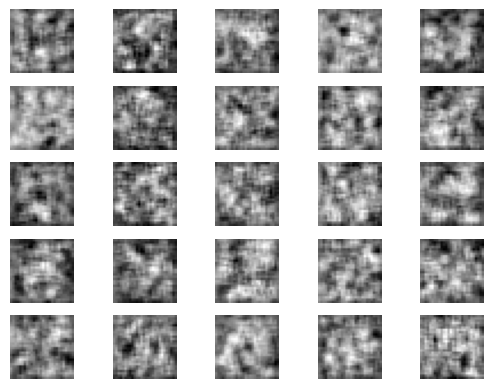

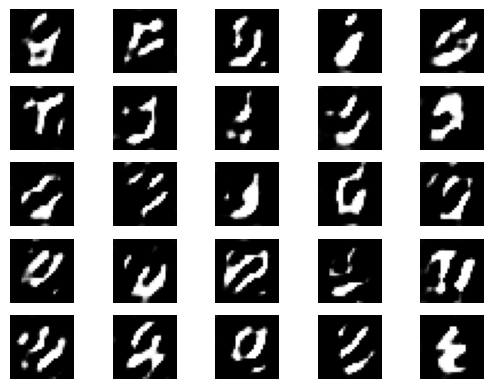

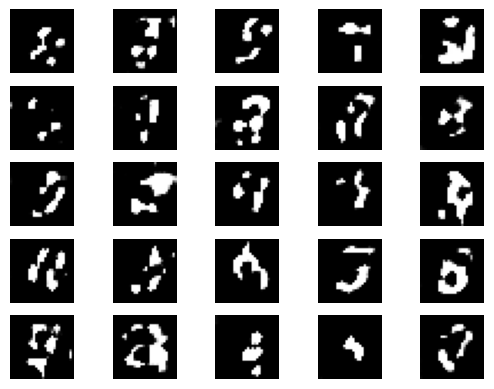

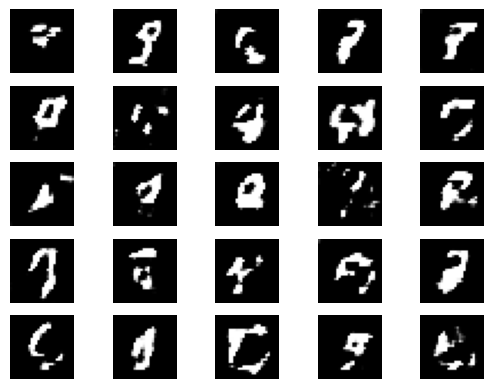

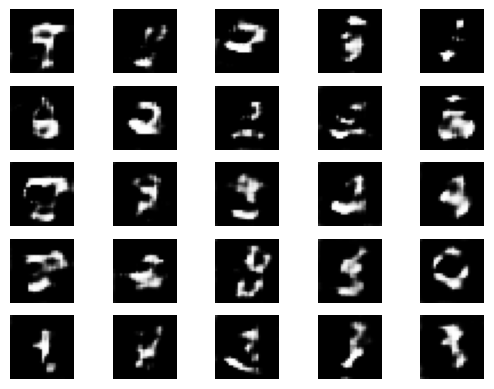

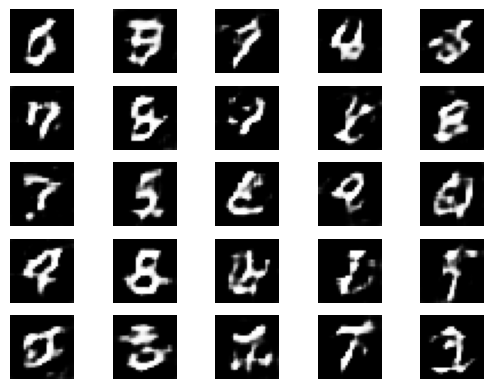

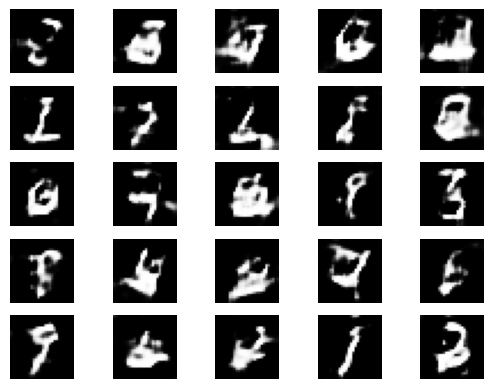

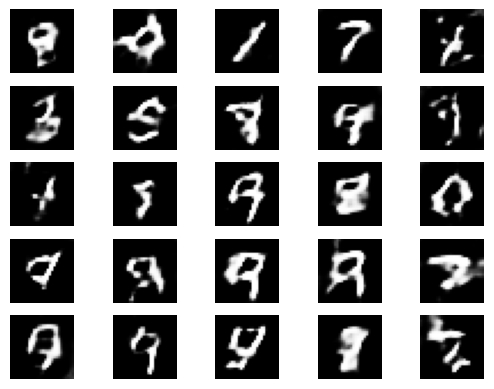

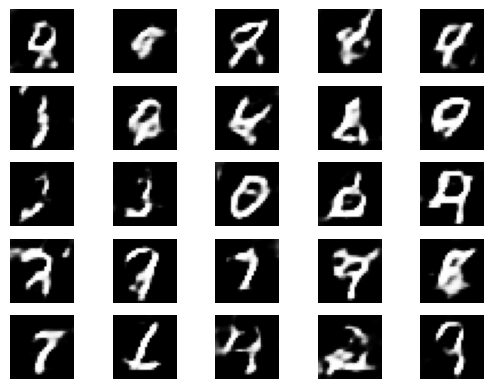

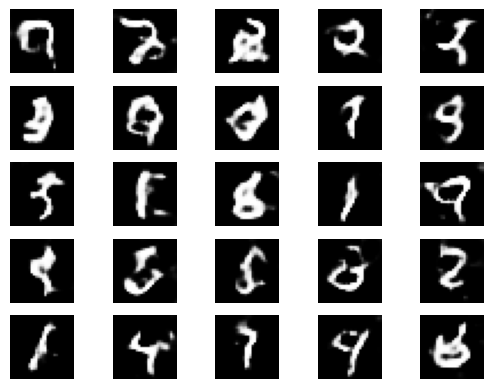

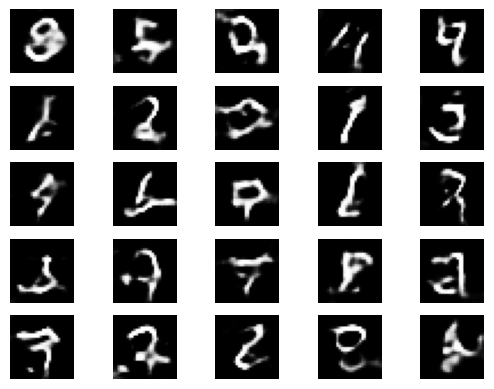

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt
import os
os.makedirs("./data/gan_images", exist_ok=True)

# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          discriminator.trainable = True
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise, verbose=0)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          discriminator.trainable = False    #판별자 학습이 끝나면 trainable = False로 만들어 판별자는 그대로 둔 채 생성자만 학습합니다.
          noise = np.random.normal(0, 1, (batch_size, 100))

          g_loss = gan.train_on_batch(noise, true)

          if i % 100 == 0:  #100 epoch마다 출력되게 하겠습니다.
            print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 이 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./data/gan_images/gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.


## 4. 이미지의 특징을 추출하는 오토인코더

### 실습: 오토인코더 실습하기

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분입니다.
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인합니다.
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):        # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.3038 - val_loss: 0.1381
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1329 - val_loss: 0.1195
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1186 - val_loss: 0.1108
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1103 - val_loss: 0.1055
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1057 - val_loss: 0.1027
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1031 - val_loss: 0.1003
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1013 - val_loss: 0.0984
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0995 - val_loss: 0.0971
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0979 - val_loss: 0.0957
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0969 - val_loss: 0.0946
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0955 - val_loss: 0.0945
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/st